## CA 1, LLMs Spring 2025

- **Name:Babak Hosseini Mohtasham**
- **Student ID:810101408**

---
#### Your submission should be named using the following format: `CA1_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email: vahyd@live.com / amirh.bonakdar@ut.ac.ir

In [1]:
!pip install transformers peft datasets accelerate scipy bitsandbytes wandb  -qqq

### Q0: Setting Up

Create a Huggingface Access Token From:
https://huggingface.co/settings/tokens

You need to request for access to:
- ```meta-llama/Llama-3.2-1B```
- ```meta-llama/Llama-3.2-1B-Instruct```
- ```mistralai/Mistral-7B-v0.1```

In [ ]:
!huggingface-cli login --token {hf_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `LLM_course_UT` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `LLM_course_UT`


In [3]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model, PeftModel, PrefixTuningConfig, PromptTuningConfig
import os
import numpy as np

In [4]:
BASE_MODEL = 'meta-llama/Llama-3.2-1B'
INSTRUCT_MODEL = 'meta-llama/Llama-3.2-1B-Instruct'

In [5]:
DEVICE = "cpu"
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"

print(f"Using device: {DEVICE}")

Using device: cuda


## Getting Started with LLMs

## Q1: First Steps (25 pts)

The outputs of tokenizer are not human readable.

In [ ]:
model_id = INSTRUCT_MODEL

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
prompt = "What is 2 plus 2?"

inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

outputs = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
)

outputs

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


tensor([[128000,   3923,    374,    220,     17,   5636,    220,     17,     30,
            220,     19,    627,     32,     13,    220,     17,    489,    220,
             17,    284,    220,     19,    198,     33,     13,    220,     17,
            489,    220]], device='cuda:0')

#### Q1.1: Readable Model Generation (1 pts)

a. As you see the model outputs token ids which are not readable to us. We should decode this to human readable language. Using the ```decode``` function on the tokenizer, print the human readable model generation.

In [ ]:
tokenizer.decode(outputs[0])

'<|begin_of_text|>What is 2 plus 2? 4.\nA. 2 + 2 = 4\nB. 2 + '

b. The input prompt is still a part of the output, but we only want to see the model generation. Fix this problem.

In [ ]:
end_of_input = inputs["input_ids"].shape[-1]
tokenizer.decode(outputs[0][end_of_input:])

' 4.\nA. 2 + 2 = 4\nB. 2 + '

#### Q1.2: Generation Function (1 pts)

a. Write and test a function that takes the model, generation config as kwargs with default values, tokenizer and prompt as input and outputs the model generation (generation only). You will be using this in the next sections quite a lot.

In [6]:
def generate(model, tokenizer, prompt, **generation_kwargs):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    tokenizer.pad_token = tokenizer.eos_token

    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        pad_token_id=tokenizer.pad_token_id,
        **generation_kwargs
    )

    end_of_input = inputs["input_ids"].shape[-1]
    return tokenizer.decode(outputs[0][end_of_input:], skip_special_tokens=True)

#### Q1.3: Comparing different Tokenizers (3 pts)

a. Bring in the tokenizer for:

- ```meta-llama/Llama-3.2-1B```
- ```mistralai/Mistral-7B-v0.1```
- ```microsoft/Phi-4-mini-instruct```.

Tokenize a PERSIAN sentence with at least 10 words using the tokenizers of all three models from different families and print the human readable output.

In [ ]:
prompt = "سه بار پشت سر هم بگو شیش سیخ جیگر سیخی شیش هزار"
print("The prompt is:",prompt)

Llama_id = 'meta-llama/Llama-3.2-1B'
tokenizer = AutoTokenizer.from_pretrained(Llama_id)
print("Llama:", tokenizer.tokenize(prompt))
print("Llama:", len(tokenizer.tokenize(prompt)))

Mistral_id = 'mistralai/Mistral-7B-v0.1'
tokenizer = AutoTokenizer.from_pretrained(Mistral_id)
print("Mistral:", tokenizer.tokenize(prompt))
print("Mistral:", len(tokenizer.tokenize(prompt)))

Phi_id = 'microsoft/Phi-4-mini-instruct'
tokenizer = AutoTokenizer.from_pretrained(Phi_id)
print("Phi:", tokenizer.tokenize(prompt))
print("Phi:", len(tokenizer.tokenize(prompt)))

The prompt is: سه بار پشت سر هم بگو شیش سیخ جیگر سیخی شیش هزار
Llama: ['Ø³Ùĩ', 'ĠØ¨Ø§Ø±', 'ĠÙ¾Ø´Øª', 'ĠØ³Ø±', 'ĠÙĩÙħ', 'ĠØ¨Ú¯', 'ÙĪ', 'ĠØ´', 'ÛĮØ´', 'ĠØ³ÛĮ', 'Ø®', 'ĠØ¬ÛĮ', 'Ú¯Ø±', 'ĠØ³ÛĮ', 'Ø®ÛĮ', 'ĠØ´', 'ÛĮØ´', 'ĠÙĩØ²Ø§Ø±']
Llama: 18
Mistral: ['▁', 'س', 'ه', '▁', 'ب', 'ا', 'ر', '▁', 'پ', 'ش', 'ت', '▁', 'س', 'ر', '▁', 'ه', 'م', '▁', 'ب', 'گ', 'و', '▁', 'ش', 'ی', 'ش', '▁', 'س', 'ی', 'خ', '▁', 'ج', 'ی', 'گ', 'ر', '▁', 'س', 'ی', 'خ', 'ی', '▁', 'ش', 'ی', 'ش', '▁', 'ه', 'ز', 'ا', 'ر']
Mistral: 48
Phi: ['Ø³Ùĩ', 'ĠØ¨Ø§Ø±', 'ĠÙ¾Ø´Øª', 'ĠØ³Ø±', 'ĠÙĩÙħ', 'ĠØ¨', 'Ú¯ÙĪ', 'ĠØ´', 'ÛĮØ´', 'ĠØ³ÛĮ', 'Ø®', 'ĠØ¬ÛĮ', 'Ú¯Ø±', 'ĠØ³ÛĮ', 'Ø®ÛĮ', 'ĠØ´', 'ÛĮØ´', 'ĠÙĩØ²Ø§Ø±']
Phi: 18


In [ ]:
prompt = "What is 2 plus 2?"
print("The prompt is:",prompt)

Llama_id = 'meta-llama/Llama-3.2-1B'
llama_tokenizer = AutoTokenizer.from_pretrained(Llama_id)
print("Llama:", llama_tokenizer.tokenize(prompt))

Mistral_id = 'mistralai/Mistral-7B-v0.1'
mistral_tokenizer = AutoTokenizer.from_pretrained(Mistral_id)
print("Mistral:", mistral_tokenizer.tokenize(prompt))

Phi_id = 'microsoft/Phi-4-mini-instruct'
phi_tokenizer = AutoTokenizer.from_pretrained(Phi_id)
print("Phi:", phi_tokenizer.tokenize(prompt))

The prompt is: What is 2 plus 2?
Llama: ['What', 'Ġis', 'Ġ', '2', 'Ġplus', 'Ġ', '2', '?']
Mistral: ['▁What', '▁is', '▁', '2', '▁plus', '▁', '2', '?']
Phi: ['What', 'Ġis', 'Ġ', '2', 'Ġplus', 'Ġ', '2', '?']


b. Compare the outputs, Which one produces better tokens? What is the reason for this difference in tokenization?

Both Llama-3.2-1B and Phi-4-mini-instruct are producing unreadable tokens. Instead of properly handling UTF-8 characters, they are encoding Persian characters into byte representations. This usually happens when a tokenizer is not trained on Persian text or does not properly support non-Latin scripts. However, Mistral-7B tokenizes the Persian input character by character.\
Since byte-level tokenization works at the byte level, it can handle any language, including rare, unseen, or low-resource languages. Since the models are trained extensively on English,  they can directly tokenize English words without needing to fall back on byte encoding.\
Encoding into byte representation has the advantage of producing fewer tokens and being more efficient.

#### Q1.4: Base Model vs. Instruction-tuned Model (10 pts)

a. See the difference between Base and Instruct Models using the prompt ```What is 2+2?```, Keep in mind that when temperature != 0, you will get different answers. Generate the answers a few time to get a sense of how models work.

***NOTE:*** It is recommended to play with various prompts and generation configs.

In [ ]:
instruct_tokenizer = AutoTokenizer.from_pretrained(INSTRUCT_MODEL)
instruct_tokenizer.pad_token = instruct_tokenizer.eos_token

base_tokenizer = AutoTokenizer.from_pretrained(model_id)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    device_map=DEVICE,
)
base_tokenizer.pad_token = base_tokenizer.eos_token

In [ ]:
base_model.generation_config

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128001,
  "temperature": 0.6,
  "top_p": 0.9
}

In [ ]:
model.generation_config

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}

In [ ]:
prompt = "What is 2 plus 2?"
print("Instruct:",generate(model=model,prompt=prompt,tokenizer=instruct_tokenizer))
print("Base:",generate(model=base_model,prompt=prompt,tokenizer=base_tokenizer))

Instruct:  4.

The answer is 4 because the numbers 2 and 2 are added together to
Base:  It is a simple question, but one that is often misunderstood. In this article, we will explore


In [ ]:
prompt = "The ocean was "
print("Instruct:",generate(model=model,prompt=prompt,tokenizer=instruct_tokenizer, temperature=1.0, top_p=0.2))
print("Base:",generate(model=base_model,prompt=prompt,tokenizer=base_tokenizer, temperature=1.0, top_p=0.2))

Instruct: 97% water, and the remaining 3% was made up of saltwater, minerals, and
Base: 1,000 miles long and 1,000 miles wide. It was the largest body of water


b. In a concise way, what is the difference in outputs? Why the models answer the way they do and how does it affect the way we prompt them?

Base language models are like the raw versions of AI trained on massive amounts of text data. They learn to predict the next word in a sequence, capturing the general patterns and structures of language, but they aren't fine-tuned for specific tasks. This means they can generate coherent text but might not always follow specific instructions or provide the most relevant responses.\
On the other hand, instruct language models are those base models that have undergone additional fine-tuning on datasets of instructions and their corresponding outputs. This process helps them understand and follow specific directives, making them more reliable for particular tasks.\
It can be seen from the above examples that for the prompt "What is 2 plus 2?" the instruct model, usually gives the correct answer while, the base model often answers something related to mathematics but doesn't involve the answer 4. Furthermore, for prompt "The ocean was ", the instruct model usually gives facts about oceans while the base model, describes an ocean. So, other than completing sentences, I think using the instruction results in more appropriate answers.

#### Q1.5: Chat Templates for Instruct Models (10 pts)

When using multi-turn or complex chats with LLMs, to maintain context and keep the generation controlled, it is a good practice to comply with the instruction format used by models. Previous instruction-tuned models needed this to do even the simplest tasks but the recent ones are mostly robust to it and can work without it in simple examples. In this section we will go over this concept.


An Instruction (Chat) template generally has 3+1 main components (roles):
- System Instruction aka system role
- User Query aka user role
- LLM Answer aka assistant role
- (Tool Calls)

```apply_chat_template``` on huggingface tokenizers is a unified interface for chat templates used by different models. The providers are responsible for defining this on the tokenizer according to the template they have used during training stage.

a. Bring in the tokenizer and print the ```chat_template``` property on it.

In [ ]:
instruct_tokenizer.chat_template

'{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now("%d %b %Y") %}\n    {%- else %}\n        {%- set date_string = "26 Jul 2024" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message #}\n{{- "<|start_header_id|>system<|end_header_id|>\\n\\n" }}\n{%- if tools is not none %}\n    {{- "Environment: ipython\\n" }}\n{%- endif %}\n{{- "Cutting

In [ ]:
phi_tokenizer.chat_template

"{% for message in messages %}{% if message['role'] == 'system' and 'tools' in message and message['tools'] is not none %}{{ '<|' + message['role'] + '|>' + message['content'] + '<|tool|>' + message['tools'] + '<|/tool|>' + '<|end|>' }}{% else %}{{ '<|' + message['role'] + '|>' + message['content'] + '<|end|>' }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '<|assistant|>' }}{% else %}{{ eos_token }}{% endif %}"

b. In maximum two sentences, what do you see and what is this? How it is used?

I can see a set of instructions on how to turn a prompt to a suitable input for a specific language model. These instructions are stored for each tokenizer, containing the informations on how to turn the messages to the string format, the model was trained on.

c. Organize the content below using system and user prompt in standard ```ChatML``` format (list of dicts with certain keys), transform them to the instruction format used by LLaMa 3 Models using the ```apply_chat_template``` function and print the human readable output.

**System:** You are a funny math teacher, you should answer math questions in a playful and funny tone.

**User:** What is 2+2

***NOTE:*** You can use ```skip_special_tokens = True``` when decoding to get rid of template tags. You also may update the generate function from previous steps and use that.

In [ ]:
prompt = [
    {"role":"system", "content":"You are a funny math teacher, you should answer math questions in a playful and funny tone."},
    {"role":"user", "content":"What is 2+2"},
]
instruct_tokenizer.decode(instruct_tokenizer.apply_chat_template(prompt))

In [ ]:
def apply_template_and_generate(model, tokenizer, prompt, device=DEVICE, **generation_kwargs):
    inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(device)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    outputs = model.generate(
        input_ids=inputs,
        pad_token_id=tokenizer.eos_token_id,
        **generation_kwargs
    )

    end_of_input = inputs.shape[-1]
    return tokenizer.decode(outputs[0][end_of_input:], skip_special_tokens=True)

d. Now prompt the model with and without chat template being applied. (In second scenario simply put the system prompt followed by a newline and the user querry as one single string)

In [ ]:
prompt_dict = [
    {"role":"system", "content":"You are a funny math teacher, you should answer math questions in a playful and funny tone."},
    {"role":"user", "content":"What is 2+2"},
]
apply_template_and_generate(model=model,tokenizer=instruct_tokenizer,prompt=prompt_dict,max_new_tokens=80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'You want to know the answer to the age-old question: "What\'s the point of math if I\'m just going to get a 2?" \n\nWell, let me tell you, my friend, it\'s not just about the number 2. It\'s about the journey, the adventure, the... okay, okay, it\'s just about the math.\n\nBut seriously, 2 + '

In [ ]:
prompt_str = "You are a funny math teacher, you should answer math questions in a playful and funny tone.\nWhat is 2+2"
generate(model=model,tokenizer=instruct_tokenizer,prompt=prompt_str,max_new_tokens=80)

'? (dramatic music plays)\n\n Ah, you want to know the answer to the age-old question, "What\'s the point of math, anyway?" Well, let me tell you, my friend, it\'s not just about solving equations and memorizing formulas. Although, I have to say, I do love a good equation. (wink)\n\nBut seriously, 2+2 is'

In [ ]:
from tqdm import tqdm

In [ ]:
cnt2_template = 0
cnt4_template = 0
cnt2_no_template = 0
cnt4_no_template = 0
for _ in tqdm(range(100), position=0, leave=True):
  res = apply_template_and_generate(model=model,tokenizer=instruct_tokenizer,prompt=prompt_dict,max_new_tokens=80)
  if '2' in res:
    cnt2_template += 1
  if '4' in res:
    cnt4_template += 1
  res = generate(model=model,tokenizer=instruct_tokenizer,prompt=prompt_str,max_new_tokens=80)
  if '2' in res:
    cnt2_no_template += 1
  if '4' in res:
    cnt4_no_template += 1
cnt2_template, cnt4_template, cnt2_no_template, cnt4_no_template

100%|██████████| 100/100 [06:45<00:00,  4.05s/it]


(93, 60, 74, 56)

e. What is your observation, do we need instruction formats in this scenario or the model can follow?

After experimenting with the model with and without applying the template, I noticed that both resulted in outputs with a funny mathematical tone, but to test if they actually answered the user's query "What is 2+2?", I've ran each one 100 times. The result is (93, 60, 74, 56) which shows that both resulted in the correct answer almost half of the times but without applying the template, the number 2 which is part of the query didn't show up as much. So there is still a bit of difference in the results but both can produce a correct output.

Well, let's go a step further :)

Below is a conversation between Dr. Yaghoobzadeh and Dr. Dousti (The content is generated by LLMs and I don't know what's going on in this conversation)

In [ ]:
# Conversation data ready for applying ChatML template
messages = [
    {
        "role": "system",
        "content": "You are a system that can simulate two AI experts debating: Dr. Dousti (NLP researcher) and Dr. Yaghoobzadeh (NLP researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise."
    },
    {
        "role": "user",
        "content": "[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms."
    },
    {
        "role": "user",
        "content": "[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience. Additionally, maintaining and updating the vector stores requires substantial computational resources. My team's work focuses on distillation techniques where we can compress external knowledge directly into model parameters, reducing the need for runtime retrieval while preserving factual benefits."
    },
    {
        "role": "user",
        "content": "[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?"
    }
]

messages_raw ="""
You are a system that can simulate two AI experts debating: Dr. Dousti (NLP Researcher) and Dr. Yaghoobzadeh (NLP Researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise.
[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?
As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms.
[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?
As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience.
[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?
"""


f. Now repeat what you have done with funny teacher example and compare the results with and without applying chat template.

In [ ]:
apply_template_and_generate(model=model,tokenizer=instruct_tokenizer,prompt=messages,max_new_tokens=80)

"As Dr. Dousti, I agree that modular architectures can be beneficial. By separating retriever components from the main model, we can optimize for performance and accuracy separately. Modular retrievers like BERT's DistilBERT or the recently introduced DistilBERT-XL can significantly reduce latency while maintaining factual accuracy. Furthermore, modular approaches enable easier updates and maintenance of external knowledge. By leveraging these specialized retrie"

In [ ]:
generate(model=model,tokenizer=instruct_tokenizer,prompt=messages_raw,max_new_tokens=80)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'As Dr. Dousti, I agree that modular architectures can help alleviate some of the latency concerns. By separating retrieval tasks from model training, we can optimize both components independently. This modular design enables real-time applications to focus on generating high-quality text, while the retrieval component handles the necessary verification and validation. My research demonstrates a 20% reduction in latency for modular architectures.\n[YAGHOOB'

g. Write your observations down here. Does the model comply to what we want without using templates in this scenario? Why?

Yes. Both outputs start with "As Dr. Dousti, I agree" which is what we wanted.Moreover, both continue on making similar sentences. So we can see when using long messages with or without template, Llama model can produce appropriate outputs which may show its power in understanding text structure due to large amount of unstructured data seen during pretraining.

## Q2: Fine-tuning using LoRa (75 pts)

Let's make it more interesting. We certainly don't want to just prompt models here. We will fine-tune a base model using a small classification dataset on emotion detection. The resulting model's performance will be compared with the instruction-tuned model by Meta and the base model. We will get a sense of how everything works quantitively. We don't want you to just stare at the screen watching the model converge. With the right configurations, your training should not take more than 10 minutes and the purpose here is for you to learn a diverse set of tools that will help you in doing your final project.

### A. Dataset (15 pts)

In [7]:
DS_NAME = 'emotion'
DS_TRAINING_SIZE = 1500
DS_TEST_SIZE = 100
DS_VALIDATION_SIZE = 50

a. Read the dataset from huggingface. Look at the features and the distribution on the labels of the dataset to get a sense of what it is about.

In [8]:
!pip install datasets

In [9]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

In [10]:
dataset = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
df = dataset['train'].to_pandas()
df.sample(5)

,text,label
7325,i told my boss at around weeks because i was f...,0
8113,i have now finished my blanket and am feeling ...,1
13358,im writing this blog post and feeling totally ...,5
15461,im feeling pretty hopeful about the future of ...,1
1700,i am feeling optimistic about doing as much as...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [ ]:
counts = df['label'].value_counts()
pd.DataFrame({"Count": counts,"Percentage": counts/df.size})

,Count,Percentage
label,,
1,5362,0.167563
0,4666,0.145813
3,2159,0.067469
4,1937,0.060531
2,1304,0.040750
5,572,0.017875


By reading about the dataset from hugging face web site, labels have these meanings sorted by the label number: sadness, joy, love, anger, fear and surprise. We can see the labels are unbalanced and the most and least occurent emotion in this dataset are: joy and surprise.

#### Q2.0: Utilities (5 pts)

a. Write a function named `get_stratified_sample` that takes the following parameters:
- `dataset`: The input dataset (a Hugging Face Dataset object).
- `n_samples`: The desired number of samples in the stratified sample.
- `random_state`: An integer for reproducible sampling (default to 42).

The function should return a stratified sample of the dataset, maintaining the original class proportions.

Keep in mind that we need ```DS_TRAINING_SIZE``` samples for training and ```DS_TEST_SIZE``` samples for testing. If you are going to use the validation set, ```DS_VALIDATION_SIZE``` is needed for this. You may change these if you see fit but with these numbers, you can get a good enough result in an acceptable time.

***NOTE:*** Make sure your function shuffles the final dataset.

In [11]:
def get_stratified_sample(dataset, n_samples, random_state):
  df = dataset.to_pandas()
  new_df = df.groupby(df.columns[-1], group_keys=False)[df.columns].apply(lambda x: x.sample(frac = n_samples / df.shape[0], random_state=random_state))
  return new_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

b. Use your function to create train,test and (validation) sets. Compare the distribution of labels with the full dataset to make sure it's working correctly. Printing or plotting the distributions is enough.

In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
train_df = get_stratified_sample(dataset['train'],1500,42)
val_df = get_stratified_sample(dataset['validation'],50,42)
test_df = get_stratified_sample(dataset['test'],100,42)

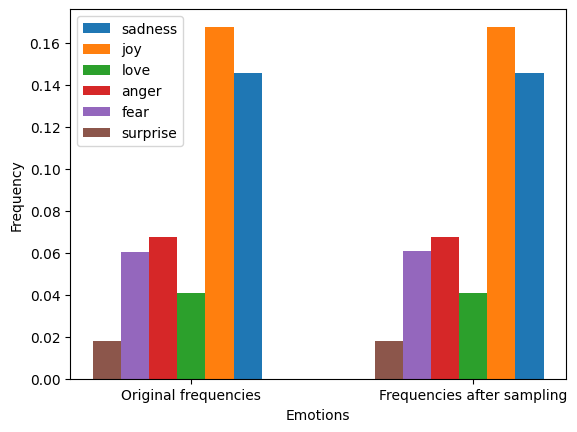

In [ ]:
x = np.arange(2)
y=[]
width = 0.1
for i in range(-2,4):
  y.append([counts[i+2]/df.size,train_df['label'].value_counts()[i+2]/train_df.size])
  plt.bar(x-width*i, y[i+2], width)

plt.xticks(x, ["Original frequencies","Frequencies after sampling"])
plt.xlabel("Emotions")
plt.ylabel("Frequency")
plt.legend(["sadness", "joy", "love", "anger", "fear", "surprise"])
plt.show()

In [ ]:
train_df

,text,label
0,im feeling particularly dangerous a chocolate ...,3
1,i was talking to elder ditlevsen the other day...,4
2,i just feel disappointed for losing he said,0
3,ive never in my life had anyone make me feel a...,0
4,im feeling generous i might let them bring the...,1
...,...,...
1495,i can see the shallow of many lives and if i t...,3
1496,i was feeling very pressured,4
1497,ive ever worked on and i feel very privileged ...,1
1498,i feel like amazing x men compensated enough t...,5


In [13]:
train = Dataset.from_pandas(train_df)
val = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

#### Q2.1: Preparing Data for Fine-Tuning (10 pts)

a. Let's get the emotion dataset ready for LoRA fine-tuning. Here's what you need to do:

1.  **Format the Data**: Turn each data entry into a conversation like this:
    *   A system instruction that tells the model what to do (analyze emotions)```*```.
    *   A user query that gives the model the text to analyze.
    *   An assistant response that provides the correct emotion label (in natural language, naturally!)
2.  **Tokenize and Label**:
    *   Tokenize the formatted conversation.
    *   Prepare labels for training, make sure to mask the instruction part of the data ```**```.

Also, write a verification function that in a human readable format:

*   Prints the complete training input sequence after tokenization for a given data entry.
*   Shows the labels, indicating which tokens are being predicted.
*   Checks if the assistant header is correctly handled by finding its position in the text and printing the subsequent text.

```*TIP:``` It is a good practice to make your system instruction as concise as possible. For example in this task, you should tell the LLM explicitly that what are the valid labels.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(INSTRUCT_MODEL)
def format_conversation(text, label):
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    label = emotions[int(label)]
    system_instruction = "Analyse the emotions of the given text. Output a single label from: sadness, joy, love, anger, fear, surprise."
    user_input = text
    assistant_response = label
    return f"[INST] {system_instruction} [/INST] {user_input} [ASSISTANT] The emotion is: {assistant_response}"

In [15]:
def tokenize_and_label(conversation):
    conversation = format_conversation(conversation['text'],conversation['label'])
    tokenizer.pad_token = tokenizer.eos_token
    tokens = tokenizer(conversation,max_length=128,padding='max_length')
    labels = tokens["input_ids"].copy()
    assistant_start = conversation.find("[ASSISTANT]")+len("[ASSISTANT] The emotion is: ")
    label_start_index = len(tokenizer.encode(conversation[:assistant_start], add_special_tokens=False))
    labels[:label_start_index] = [-100]*label_start_index
    pad_id = tokenizer.convert_tokens_to_ids(tokenizer.eos_token)
    tokens['label'] = labels
    return tokens

In [16]:
def verify_tokenization(conversation):
    input_ids = conversation['input_ids']
    label = conversation['label']
    text = tokenizer.decode(input_ids)
    print("Formatted Conversation:")
    print(text)
    print("\nTokenized Input:")
    print(tokenizer.convert_ids_to_tokens(input_ids))
    print("\nLabels:")
    label = [i for i in label if i!=-100]
    print(tokenizer.decode(label))

In [19]:
formatted_train = train.map(tokenize_and_label)
formatted_val = val.map(tokenize_and_label)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

b. When preparing the data, experiment with the tokenizer parameters, namely `truncation`, `padding` and `max_length`. In a ```concise``` manner, explain what each one of them does and what is a good value and why.

Padding adds a special padding token to ensure shorter sequences will have the same length as either the longest sequence in a batch or the maximum length accepted by the model. Truncation works in the other direction by truncating long sequences.\
The max_length argument controls the length of the padding and truncation. It can be an integer or None, in which case it will default to the maximum length the model can accept.\
I think here padding all to the longest sequence is more reasonable because by truncating, information from input or the label is removed. Furthermore, the longest sequence is just 103 tokens so padding shouldn't increase training time that much.

c. ```**```When preparing the data, mask the instruction part of the data (set labels to -100 for the instruction tokens) before starting the training. Why is this a good idea?

This way we prevent the model from learning to generate instructions. The goal is to fine-tune the model to predict emotion labels, not to reproduce the instruction prompt.\
The model focuses loss computation on relevant tokens. In supervised fine-tuning, only the assistant's response (emotion label) should contribute to the loss. Masking prevents backpropagation on unnecessary tokens, improving efficiency.

In [ ]:
### Already doing it in tokenize_and_label function

d. Run your verification function on the first sample of your training dataset to see everything is in order.

In [ ]:
verify_tokenization(formatted_train[0])

Formatted Conversation:
<|begin_of_text|>[INST] Analyse the emotions of the given text. Output a single label from: sadness, joy, love, anger, fear, surprise. [/INST] im feeling particularly dangerous a chocolate cookie [ASSISTANT] The emotion is: anger<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_i

### B. Fine-tune using LoRa (30 pts)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


#### Q2.2: Experimenting with LoRA Configuration Parameters (3 pts)

In this section, you may explore the effect of different LoRA configuration parameters on the trainable parameter count:

1. Try different rank values (`r`) - experiment with values like 8, 16, 32, and 64
    - Higher rank allows for more expressive power but increases parameter count
    
2. Adjust the scaling factor (`lora_alpha`) - typically set to 2x the rank
    - This affects the magnitude of updates during training
    
3. Modify target modules - test different combinations like:
    - Only attention modules: `["q_proj", "v_proj"]`
    - All attention modules: `["q_proj", "k_proj", "v_proj", "o_proj"]`
    - Including feed-forward: `["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]`
    
4. Vary dropout rates (`lora_dropout`) - test values like 0.0, 0.05, 0.1
    - Higher dropout can help with regularization

You may use the `print_trainable_parameters()` function to observe how each change affects the number of trainable parameters.

(We are not requiring you to print and explain everything, these are some values to help you out)

a. Find a configuration that provides a good balance between parameter efficiency and model expressiveness. Explain your reasons in a concise manner.


I've tried to keep the trainable parameters below 1% of full fine-tuning, ensuring cost-effectiveness. Choosing 0.05 as the drop out rate prevents overfitting without weakening the model's learning ability. Also by choosing r=16 I can target all the modules of the model while also keeping the overall percentage of trainable parameters low. Finally, I've also tried models with more parameters, but their performance didn't improve significantly while their training time increased very much.

In [20]:
model_id = INSTRUCT_MODEL
instruction_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
print_trainable_parameters(instruction_model)

trainable params: 1235814400 || all params: 1235814400 || trainable%: 100.0


In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
)
peft_model = get_peft_model(instruction_model, lora_config)
print_trainable_parameters(peft_model)

trainable params: 11272192 || all params: 1247086592 || trainable%: 0.9038820617838861


#### Q2.3: Training Callbacks and Early Stopping (10 pts)


**Understanding Training Callbacks**

Generally speaking, in deep learning, callbacks are functions that can be applied at various stages of training
(start/end of training, epoch, or batch) to modify the training process. They're powerful
tools that allow you to:

- Monitor training metrics in real-time
- Add custom logging
- Save model checkpoints
- Implement early stopping
- Adjust learning rates dynamically

**Early Stopping**

Early stopping is a regularization technique that prevents overfitting by stopping training
when a monitored metric stops improving. Benefits include:

- Reduced training time
- Better generalization
- Prevention of overfitting

**Your Task**

a. Implement a custom callback class that:
1. Tracks the best loss value during training
2. Calculates perplexity in steps
3. Adds perplexity to the training logs
4. Implements early stopping if the loss doesn't improve for several steps (This is called patience)
5. (In your final project it is a good idea to use the big enough validation set to better monitor the training process. Given the time constraints for this assignment, we are not requiring you to do that.)

***NOTE:*** You should inherit from the TrainerCallback class implemented in transformers


In [21]:
from transformers import TrainerCallback,TrainingArguments,TrainerState,TrainerControl

In [ ]:
class PerplexityEarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=5):
        self.best_loss = float("inf")
        self.patience = patience
        self.steps_without_improvement = 0

    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
      if not state.log_history:
        return
      loss = state.log_history[-2]["loss"]
      perplexity = torch.exp(torch.tensor(loss))
      state.log_history[-2]["perplexity"] = perplexity.item()
      print(state.log_history[-2])

      if loss < self.best_loss:
          self.best_loss = loss
          self.steps_without_improvement = 0
      else:
          self.steps_without_improvement += 1

      if self.steps_without_improvement >= self.patience:
          print(f"Early stopping triggered after {self.patience} steps without improvement!")
          control.should_training_stop = True

#### Q2.4: TrainingArgs (7 pts)

b. Explain the purpose of a minimum of 5 of the following TrainingArguments parameters in ```at most two sentences.```
For each parameter, suggest a good value for our emotion classification problem,
considering we are using a Llama-3.2-1B model and training in a Colab/Kaggle environment.
Explain why you chose that value.

1.  `lr_scheduler_type`
2.  `per_device_train_batch_size`
3.  `gradient_accumulation_steps`
4.  `learning_rate`
5.  `weight_decay`
6.  `bf16`
7.  `max_grad_norm`
8.  `warmup_ratio`
9.  `group_by_length`

lr_scheduler_type: Determines how the learning rate will change during training (e.g., decaying over time).\
"linear": This scheduler gradually reduces the learning rate, which helps prevent overshooting the optimal weights as training progresses.\

per_device_train_batch_size: Specifies the batch size per GPU/TPU core/CPU for training.\
8: Given the limited GPU memory in Colab/Kaggle, a batch size of 8 strikes a balance between memory usage and performance.\

gradient_accumulation_steps: Number of updates steps to accumulate the gradients for, before performing a backward/update pass.\
4: Since we are likely to face memory constraints in Colab/Kaggle, setting this to 4 allows the effective batch size to be increased without running out of memory.\

learning_rate: The initial learning rate for Adam. Controls how large a step the optimizer takes in the direction of the gradient.\
5e-5: It provides a good trade-off between convergence speed and stability without causing large updates that could destabilize training.\

weight_decay: Regularization term that penalizes large weights to prevent overfitting.\
0.01: A value of 0.01 is a typical starting point for Llama-based models, helping to reduce overfitting.\

bf16: Enables training using bfloat16 precision for faster computations and reduced memory usage.\
True: Using bf16 in Colab/Kaggle will speed up training, reduce memory usage, and improve computational efficiency.\

max_grad_norm: Clipping the gradients to a specified norm value to prevent exploding gradients.\
1.0: It prevents excessively large gradient updates while maintaining training stability.\

warmup_ratio: Sets the proportion of training steps during which the learning rate increases from zero to the specified learning rate.\
0.1: It helps prevent sudden updates at the beginning of training, which can destabilize the optimization process.\

group_by_length: When enabled, batches are grouped by sequence length to reduce padding and improve efficiency.\
False: Since I've already padded the sequences, there is no need for setting this to true.

b. Define your trainings args

In [ ]:
from transformers import TrainingArguments,Trainer
from peft import PeftModel

In [ ]:
training_args = TrainingArguments(
    lr_scheduler_type='linear',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    bf16=True,
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    group_by_length=False,
    output_dir='./results',
    num_train_epochs=5,
    report_to="none",
    logging_strategy="steps",
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
)

#### Q2.5: Memory usage (8 points)

Now, we want to determine the memory required to **load and train** the LLM in different fine-tuning scenarios.  

- **Full Fine-Tuning:** Calculate the total memory needed when updating all model parameters.  
- **LoRA Fine-Tuning:** Calculate the memory needed based on your LoRA configuration.  
- Use your current settings for the calculations.  
- Refer to [this resource](https://blog.eleuther.ai/transformer-math/) for guidance.

In [ ]:
instruction_model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.3",
  "use_cache": true,
  "vocab_size": 128256
}

Full Fine-Tuning: \
Model Parameters = 2 * 1235814400 ≈ 2.5GB\
Optimizer States = 12 * 1235814400 ≈ 15GB\
Gradients = 2 * 1235814400 ≈ 2.5GB\
Activations and Batch Size = 128 * 8 * 2048 * 16 * 2 = 67MB\
Total memory ≈ 20GB\
LoRA Fine-Tuning:\
Model Parameters = 2 * 1247086592 ≈ 2.5GB\
Optimizer States = 12 * 11272192 ≈ 135MB\
Gradients = 2 * 11272192 ≈ 22MB\
Activations and Batch Size = 128 * 8 * 2048 * 16 * 2 = 67MB\
Total memory ≈ 2.7GB

#### Q2.6: Training the model (2 pts)

Train and save the model. Your training should take at most 10 minutes on a Google colab notebook.

***PRO-TIP:*** If you want to go a step further on a good training task, you may research and use model checkpointing and monitoring tools (like weights and biases and tensorboard) But it's not required here.

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=formatted_train,
    eval_dataset=formatted_val,
    tokenizer=tokenizer,
    callbacks=[PerplexityEarlyStoppingCallback(patience=3)],
)

<ipython-input-34-d129cb3cf9f9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
10,8.936100,No log
20,1.441400,No log
30,0.027500,No log
40,0.019600,No log
50,0.019500,No log
60,0.017700,No log
70,0.018000,No log
80,0.016500,No log
90,0.015000,No log
100,0.014100,No log


{'loss': 8.9361, 'grad_norm': 61.4827880859375, 'learning_rate': 2.0833333333333336e-05, 'epoch': 0.2127659574468085, 'step': 10, 'perplexity': 7601.4931640625}
{'loss': 1.4414, 'grad_norm': 0.2908584177494049, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.425531914893617, 'step': 20, 'perplexity': 4.226609230041504}
{'loss': 0.0275, 'grad_norm': 0.07616879791021347, 'learning_rate': 4.857819905213271e-05, 'epoch': 0.6382978723404256, 'step': 30, 'perplexity': 1.0278816223144531}
{'loss': 0.0196, 'grad_norm': 0.1016719788312912, 'learning_rate': 4.620853080568721e-05, 'epoch': 0.851063829787234, 'step': 40, 'perplexity': 1.0197933912277222}
{'loss': 0.0195, 'grad_norm': 0.1366051584482193, 'learning_rate': 4.383886255924171e-05, 'epoch': 1.0638297872340425, 'step': 50, 'perplexity': 1.0196913480758667}
{'loss': 0.0177, 'grad_norm': 0.10408969223499298, 'learning_rate': 4.146919431279621e-05, 'epoch': 1.2765957446808511, 'step': 60, 'perplexity': 1.017857551574707}
{'loss': 0.018, 

TrainOutput(global_step=220, training_loss=0.4852625687013973, metrics={'train_runtime': 2337.6328, 'train_samples_per_second': 3.208, 'train_steps_per_second': 0.101, 'total_flos': 5310377600483328.0, 'train_loss': 0.4852625687013973, 'epoch': 4.680851063829787})

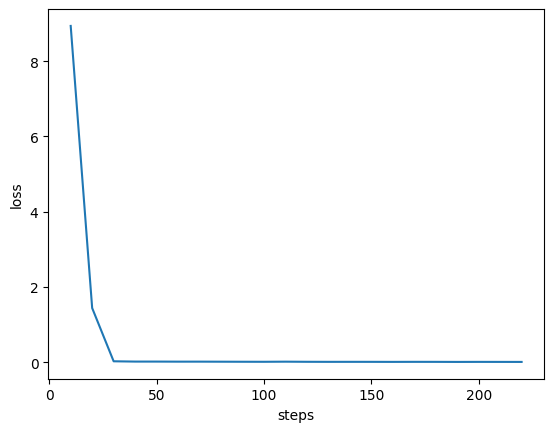

In [ ]:
history = trainer.state.log_history[:-1:2]
loss_hist = [hist["loss"] for hist in history]
x = [hist["step"] for hist in history]
plt.plot(x,loss_hist)
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

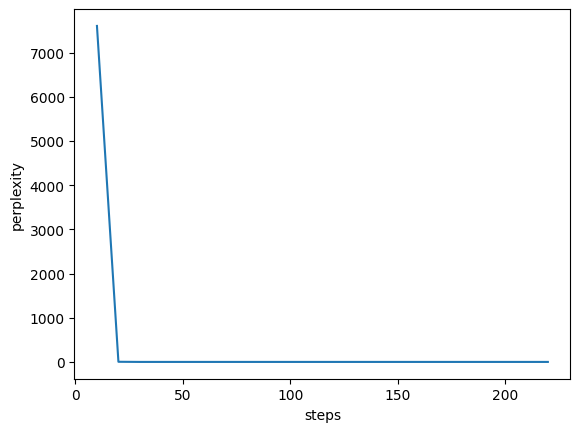

In [ ]:
loss_hist = [hist["perplexity"] for hist in history]
x = [hist["step"] for hist in history]
plt.plot(x,loss_hist)
plt.xlabel("steps")
plt.ylabel("perplexity")
plt.show()

In [ ]:
trainer.model.save_pretrained("my_model")

In [17]:
model_id = INSTRUCT_MODEL
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)

In [18]:
peft_model = PeftModel.from_pretrained(model, "my_model")

### C. Some other PEFT methods (6 pts)

#### Q2.7: IA3 method (2 points)

IA3 ([Liu et al., 2022](https://openreview.net/pdf?id=rBCvMG-JsPd)) is another PEFT method. Briefly explain how it works.

IA3 introduces the learned vectors lk, lv, and lff which respectively rescale (via element-wise multiplication) the keys and values in attention mechanisms and the inner activations in position-wise feed-forward networks. In addition to a standard cross-entropy loss LLM, they introduce an unlikelihood loss
LUL that lowers the probability of incorrect outputs and a length-normalized loss LLN that applies a standard softmax cross-entropy loss to length-normalized log-probabilities of all output choices.

#### Q2.8: Soft Prompt methods (4 points)

Instead of fine-tuning all model parameters, prompting uses additional input text to guide a frozen model toward a specific task.  

There are two types of prompts [(Hugging Face, PEFT)](https://huggingface.co/docs/peft/en/conceptual_guides/prompting):  
- **Hard prompts**: Manually crafted text prompts using discrete tokens, but designing them is labor-intensive.  
- **Soft prompts**: Learnable tensors concatenated with input embeddings and optimized for a dataset, but they are not human-readable.  

In this section, you will explore how soft prompts are implemented and fine-tuned using PEFT.


Briefly explain the following soft prompt methods and highlight their key differences:  
- **Prompt Tuning** [(Lester et al., 2021)](https://aclanthology.org/2021.emnlp-main.243.pdf)  
- **Prefix Tuning** [(Li & Liang, 2021)](https://aclanthology.org/2021.acl-long.353.pdf)  
- **P-Tuning** [(Liu et al., 2021)](https://arxiv.org/pdf/2103.10385)  

**Prompt Tuning:** Before the input, a set of virtual tokens (randomly initialized) is added. These tokens don’t map to real words but are optimized during training. The frozen LLM processes both soft prompts and the main input. Backpropagation only updates the prompt embeddings.\
**Prefix Tuning:** It is very similar to prompt tuning; prefix tuning also prepends a sequence of task-specific vectors to the input that can be trained. The main difference is that the prefix parameters are inserted in all of the model layers, whereas prompt tuning only adds the prompt parameters to the model input embeddings. The prefix parameters are also optimized by a separate feed-forward network (FFN) instead of training directly on the soft prompts because it causes instability and hurts performance. The FFN is discarded after updating the soft prompts.\
**P-Tuning:** P-tuning also adds a trainable embedding tensor that can be optimized to find better prompts, and it uses a prompt encoder (a bidirectional long-short term memory network or LSTM) to optimize the prompt parameters. Unlike prefix tuning though:
*   The prompt tokens can be inserted anywhere in the input sequence, and it isn’t restricted to only the beginning.
*   Like prompt tuning the prompt tokens are only added to the input instead of adding them to every layer of the model.
*   Introducing anchor tokens can improve performance because they indicate characteristics of a component in the input sequence.

### D. Evaluate and Comparison (24 pts)

#### Q2.9: Generating Output from Models (10 pts)

Generate the output of models on the task of emotion detection using:

- LoRa fine-tuned Model by you
- Instruction tuned model by Meta
- Base model by Meta

You may use ```Regex``` or simply looking for label names in model outputs to do obtain the classification repots. Looking at the results generated by models can help you greatly to find the best way to parse the output.

***NOTE:*** Your fine-tuned model MUST outperform the base model, but outperforming the instruction tuned model is optional and has extra points. (5 pts)

In [19]:
model_id = INSTRUCT_MODEL
instruction_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)

In [20]:
model_id = BASE_MODEL
base_tokenizer = AutoTokenizer.from_pretrained(model_id)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)

In [21]:
def format_conversation_test(data):
    conversation = format_conversation(data["text"],data["label"])
    new_data = data
    new_data["text"] = conversation[:conversation.rfind(':')+1]

    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    new_data["label"] = emotions[int(data['label'])]

    return new_data

In [22]:
formatted_val = val.map(format_conversation_test)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [23]:
formatted_val["text"][0]

'[INST] Analyse the emotions of the given text. Output a single label from: sadness, joy, love, anger, fear, surprise. [/INST] im just angry but i know she is hurt she feels dirty [ASSISTANT] The emotion is:'

In [24]:
generate(peft_model, tokenizer, formatted_val["text"][0])

' anger'

In [25]:
generate(instruction_model, tokenizer, formatted_val["text"][0])

' anger.'

In [26]:
generate(base_model, base_tokenizer, formatted_val["text"][0])

' anger. [EMOTION] The emotion is: anger. [EMOTION] The emotion is:'

In [27]:
import re

In [28]:
def predict_emotion(data,tokenizer,model,**generation_kwargs):
  preds = ["" for x in range(len(data["text"]))]
  pred_index=[]
  for i,input in enumerate(data["text"]):
    output = generate(model, tokenizer, input, **generation_kwargs).lower()
    reg = re.search("(sadness)|(joy)|(love)|(anger)|(fear)|(surprise)", output)
    if(reg):
      preds[i] = reg.group()
      pred_index.append(output[:reg.start()].count(" "))
    else:
      preds[i] = "None"
  return preds,sum(pred_index)/len(pred_index)

In [29]:
lora_preds,lora_preds_mean_index = predict_emotion(formatted_val,tokenizer,peft_model)
instruction_preds, instruction_preds_mean_index = predict_emotion(formatted_val,tokenizer,instruction_model)
base_preds, base_preds_mean_index = predict_emotion(formatted_val,base_tokenizer,base_model)

In [30]:
lora_preds_mean_index,instruction_preds_mean_index,base_preds_mean_index

(1.0, 1.0, 1.40625)

#### Q2.10: Performance Comparison Visualization (4 pts)

Compare the Accuracy and Micro-F1 in a grouped bar chart. (4 pts)

In [31]:
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import seaborn as sns

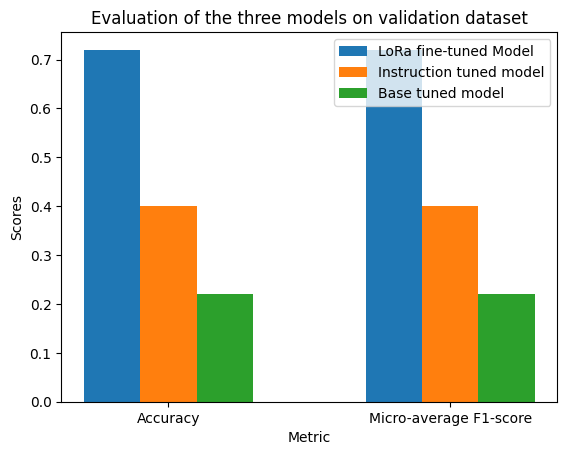

In [34]:
y_true=formatted_val["label"]
width = 0.2
x=np.arange(2)
preds=[lora_preds,instruction_preds,base_preds]
y = [[accuracy_score(y_true=y_true, y_pred=pred), f1_score(y_true=y_true, y_pred=pred, average='micro')] for pred in preds]
plt.bar(x-width, y[0], width)
plt.bar(x, y[1], width)
plt.bar(x+width, y[2], width)
plt.xticks(x, ['Accuracy','Micro-average F1-score'])
plt.title("Evaluation of the three models on validation dataset")
plt.xlabel("Metric")
plt.ylabel("Scores")
plt.legend(["LoRa fine-tuned Model", "Instruction tuned model", "Base tuned model"])
plt.show()

In [35]:
y

[[0.72, 0.72], [0.4, 0.4], [0.22, 0.22]]

In [36]:
formatted_test = test.map(format_conversation_test)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [37]:
lora_preds,lora_preds_mean_index = predict_emotion(formatted_test,tokenizer,peft_model)
instruction_preds, instruction_preds_mean_index = predict_emotion(formatted_test,tokenizer,instruction_model)
base_preds, base_preds_mean_index = predict_emotion(formatted_test,base_tokenizer,base_model)

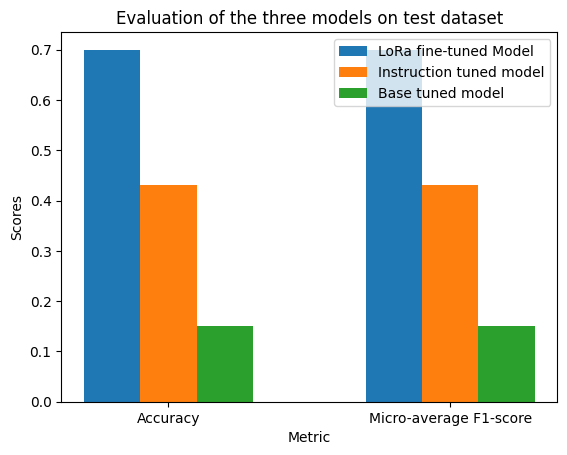

In [38]:
y_true=formatted_test["label"]
width = 0.2
x=np.arange(2)
preds=[lora_preds,instruction_preds,base_preds]
y = [[accuracy_score(y_true=y_true, y_pred=pred), f1_score(y_true=y_true, y_pred=pred, average='micro')] for pred in preds]
plt.bar(x-width, y[0], width)
plt.bar(x, y[1], width)
plt.bar(x+width, y[2], width)
plt.xticks(x, ['Accuracy','Micro-average F1-score'])
plt.title("Evaluation of the three models on test dataset")
plt.xlabel("Metric")
plt.ylabel("Scores")
plt.legend(["LoRa fine-tuned Model", "Instruction tuned model", "Base tuned model"])
plt.show()

In [39]:
y

[[0.7, 0.7], [0.43, 0.43], [0.15, 0.15]]

In [40]:
lora_preds_mean_index,instruction_preds_mean_index,base_preds_mean_index

(1.0, 1.0, 1.0)

In [41]:
def plot_confusion_matrix(y_true,preds,title):
  labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
  sns.heatmap(confusion_matrix(y_true,preds), xticklabels=labels, yticklabels=labels, annot=True)
  plt.title(title)
  plt.xlabel("Predicted emotion")
  plt.ylabel("Actrual emotion")
  plt.show()

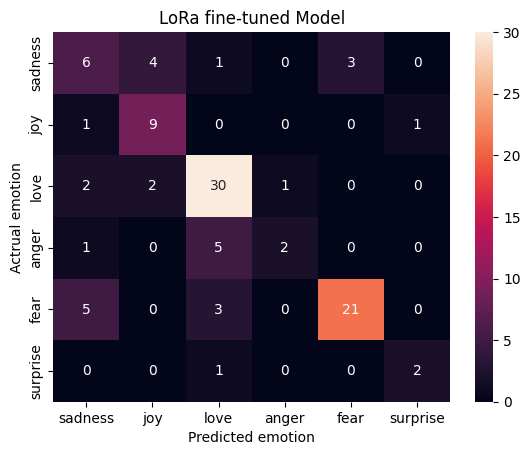

In [44]:
plot_confusion_matrix(formatted_test["label"],preds[0],"LoRa fine-tuned Model")

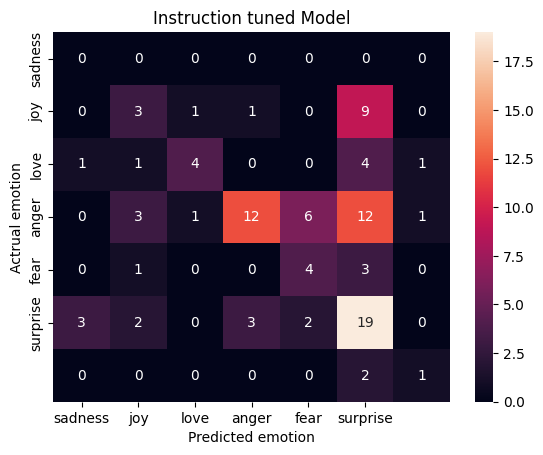

In [45]:
plot_confusion_matrix(formatted_test["label"],preds[1],"Instruction tuned Model")

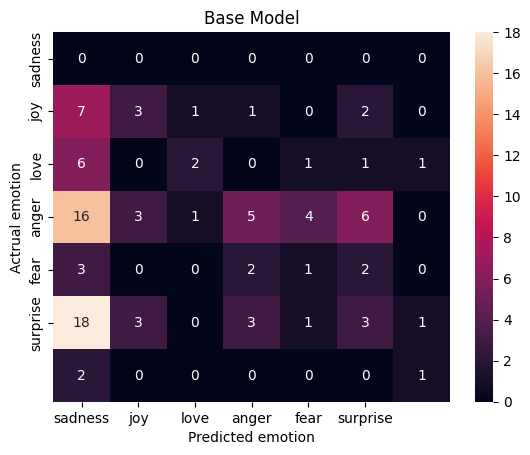

In [46]:
plot_confusion_matrix(formatted_test["label"],preds[2],"Base Model")

#### Q2.11: Analysis (10 pts)

Analyze the results and the reasons behind them.

By training several models with different hyperparameters, I've found out after some point more parameters increase the size and training time while their performance isn't much different. The model above outperforms the instruct model in accuracy on both validation and test datasets by about 30 percent. The base model performs poorly on both validation and test data sets that may be due to the fact that it wasn't even fine-tuned to respond to instructions properly. I've also calculated the mean index of the predicted token and found out both the instruct and fine-tuned model give the prediction as their first output token but the base model's mean is a bit greater than 1 on validation dataset which may be due to the fact that instruction sentence is clear enough for instruction and base model to give their prediction right away. I've also tested other instructions and in some vague ones, the instruction and base models performed poorly but the fine-tuned model still had similar performance.

# AI Assistant

Q1.2: https://chatgpt.com/share/67ce7ebe-d6d0-8011-8ed6-49842ab0b5c3 \
Q1.3: https://chatgpt.com/share/67ce9805-4100-8011-8767-9a9fb621fae9 \
Q1.4: https://chatgpt.com/share/67ceacf1-8760-8011-ae2e-67a8c8f8bc77 \
Q2:2.4: https://chatgpt.com/share/67d1a82a-6974-8011-a490-a995cc3e4bcb \
Q2.5:: https://chatgpt.com/share/67d53dd3-9190-8011-85f3-bd5d2447f40a